## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import seaborn as sns
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [6]:
# graph setting
sns.set()

In [7]:
# gpu
torch.cuda.is_available()

True

## toy data

In [8]:
# global parameter
DATA_DIR="../dlwpt-code/data/"

In [9]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_un=0.1*t_u

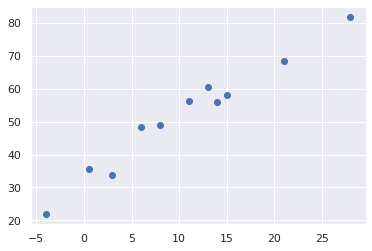

In [10]:
plt.scatter(t_c,t_u);

## 自動微分

In [11]:
def model(t_u,w,b):
    return w*t_u+b

def loss_fn(t_p,t_c):
    squared_diffs=(t_p-t_c)**2
    return squared_diffs.mean()

In [12]:
params=torch.tensor([1.0,0.0],requires_grad=True)

In [13]:
params.grad is None

True

In [14]:
loss=loss_fn(model(t_u,*params),t_c)
loss.backward()

In [15]:
params.grad

tensor([4517.2969,   82.6000])

## 自動微分を使ってtraining

In [16]:
def training_loop(n_epochs,learning_rate,params,t_u,t_c):
    for epoch in range(1,n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p=model(t_u,*params)
        loss=loss_fn(t_p,t_c)
        loss.backward()
        
        with torch.no_grad():
            params-=learning_rate*params.grad
        if epoch%500==0:
            logger.info(f"{epoch}:{loss}")
    return params

In [17]:
training_loop(5000,1e-2,
              params=torch.tensor([1.0,0.0],requires_grad=True),
              t_u=t_un,
              t_c=t_c
             )

INFO:__main__:500:7.860115051269531
INFO:__main__:1000:3.828537940979004
INFO:__main__:1500:3.092191219329834
INFO:__main__:2000:2.957697868347168
INFO:__main__:2500:2.933133840560913
INFO:__main__:3000:2.9286484718322754
INFO:__main__:3500:2.9278297424316406
INFO:__main__:4000:2.9276793003082275
INFO:__main__:4500:2.927651882171631
INFO:__main__:5000:2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

## optimizer

In [18]:
params=torch.tensor([1.0,0.0],requires_grad=True)
learning_rate=1e-5
optimizer=optim.SGD([params],lr=learning_rate)

In [19]:
t_p=model(t_un,*params)
loss=loss_fn(t_p,t_c)
optimizer.zero_grad()
loss.backward()
optimizer.step()
params

tensor([1.0008e+00, 1.0640e-04], requires_grad=True)

In [20]:
def training_loop(n_epochs,optimizer,params,t_u,t_c):
    for epoch in range(1,n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p=model(t_u,*params)
        loss=loss_fn(t_p,t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%500==0:
            logger.info(f"{epoch}:{loss}")
    return params

In [21]:
learning_rate=1e-2
params=torch.tensor([1.0,0.0],requires_grad=True)

training_loop(
    n_epochs=5000,
    optimizer=optim.SGD([params],lr=learning_rate),
    params=params,
    t_u=t_un,
    t_c=t_c
)

INFO:__main__:500:7.860119819641113
INFO:__main__:1000:3.828537940979004
INFO:__main__:1500:3.092191219329834
INFO:__main__:2000:2.957697868347168
INFO:__main__:2500:2.933133840560913
INFO:__main__:3000:2.9286484718322754
INFO:__main__:3500:2.9278297424316406
INFO:__main__:4000:2.9276793003082275
INFO:__main__:4500:2.927651882171631
INFO:__main__:5000:2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

## 演習問題

In [22]:
def model(t_u,w1,w2,b):
    return w2*t_u**2+w1*t_u+b

def loss_fn(t_p,t_c):
    squared_diffs=(t_p-t_c)**2
    return squared_diffs.mean()

In [23]:
def training_loop(n_epochs,optimizer,params,train_t_u,train_t_c,val_t_u,val_t_c):
    for epoch in range(1,n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
        train_t_p=model(train_t_u,*params)
        train_loss=loss_fn(train_t_p,train_t_c)
        
        with torch.no_grad():
            val_t_p=model(val_t_u,*params)
            val_loss=loss_fn(val_t_p,val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch%5000==0:
            logger.info(f"{epoch}:{train_loss},{val_loss}")
    return params

In [24]:
n_samples=t_u.shape[0]
n_val=int(0.2*n_samples)
shuffled_index=torch.randperm(n_samples)
train_indices=shuffled_index[:-n_val]
val_indices=shuffled_index[-n_val:]

train_t_un=t_un[train_indices]
train_t_c=t_c[train_indices]
val_t_un=t_un[val_indices]
val_t_c=t_c[val_indices]

In [25]:
learning_rate=1e-5
params=torch.tensor([1.0,0.0,0.0],requires_grad=True)

params=training_loop(
    n_epochs=50000,
    optimizer=optim.SGD([params],lr=learning_rate),
    params=params,
    train_t_u=train_t_un,
    train_t_c=train_t_c,
    val_t_u=val_t_un,
    val_t_c=val_t_c,
)

INFO:__main__:5000:12.90683364868164,10.23418140411377
INFO:__main__:10000:10.832752227783203,5.852406024932861
INFO:__main__:15000:9.17257308959961,3.089672565460205
INFO:__main__:20000:7.843672752380371,1.5437886714935303
INFO:__main__:25000:6.779921531677246,0.9010921120643616
INFO:__main__:30000:5.928390026092529,0.9180936813354492
INFO:__main__:35000:5.246720314025879,1.4064967632293701
INFO:__main__:40000:4.7010016441345215,2.221712589263916
INFO:__main__:45000:4.264084339141846,3.253389596939087
INFO:__main__:50000:3.914248466491699,4.417394161224365


In [26]:
x=np.linspace(-5,30,100)
y=model(x,*params.detach().numpy())

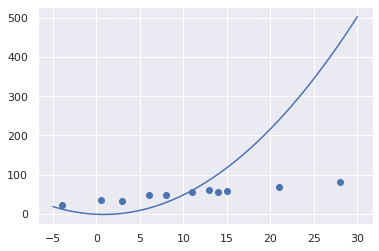

In [27]:
plt.scatter(t_c,t_u);
plt.plot(x,y)